In [1]:
import torch
import torch.nn as nn
from functools import partial
# from vit import checkpoint_filter_fn, _cfg
from PIL import Image
from timm.models.vision_transformer import checkpoint_filter_fn, _cfg
from timm.models.layers import PatchEmbed, Mlp, DropPath, trunc_normal_, lecun_normal_
%load_ext autoreload
%autoreload 2

In [16]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        assert dim % num_heads == 0, 'dim should be divisible by num_heads'
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn_score = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn_score.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn_score


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        y,attn =self.attn(self.norm1(x))
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x,attn

class VisionTransformer(nn.Module):
    """ Vision Transformer
    A PyTorch impl of : `An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale`
        - https://arxiv.org/abs/2010.11929
    Includes distillation token & head support for `DeiT: Data-efficient Image Transformers`
        - https://arxiv.org/abs/2012.12877
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=True, representation_size=None, distilled=False,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0., embed_layer=PatchEmbed, norm_layer=None,
                 act_layer=None, weight_init=''):
        """
        Args:
            img_size (int, tuple): input image size
            patch_size (int, tuple): patch size
            in_chans (int): number of input channels
            num_classes (int): number of classes for classification head
            embed_dim (int): embedding dimension
            depth (int): depth of transformer
            num_heads (int): number of attention heads
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            representation_size (Optional[int]): enable and set representation layer (pre-logits) to this value if set
            distilled (bool): model includes a distillation token and head as in DeiT models
            drop_rate (float): dropout rate
            attn_drop_rate (float): attention dropout rate
            drop_path_rate (float): stochastic depth rate
            embed_layer (nn.Module): patch embedding layer
            norm_layer: (nn.Module): normalization layer
            weight_init: (str): weight init scheme
        """
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.num_tokens = 2 if distilled else 1
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        act_layer = act_layer or nn.GELU

        self.patch_embed = embed_layer(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + self.num_tokens, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, drop=drop_rate,
                attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer, act_layer=act_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # Representation layer
        if representation_size:
            self.num_features = representation_size
            self.pre_logits = nn.Sequential(OrderedDict([
                ('fc', nn.Linear(embed_dim, representation_size)),
                ('act', nn.Tanh())
            ]))
        else:
            self.pre_logits = nn.Identity()

        # Classifier head(s)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()
        self.head_dist = None
    
        self.init_weights(weight_init)

    def init_weights(self, mode=''):
        assert mode in ('jax', 'jax_nlhb', 'nlhb', '')
        head_bias = -math.log(self.num_classes) if 'nlhb' in mode else 0.
        trunc_normal_(self.pos_embed, std=.02)
        if mode.startswith('jax'):
            # leave cls token as zeros to match jax impl
            named_apply(partial(_init_vit_weights, head_bias=head_bias, jax_impl=True), self)
        else:
            trunc_normal_(self.cls_token, std=.02)
            self.apply(_init_vit_weights)

    def _init_weights(self, m):
        # this fn left here for compat with downstream users
        _init_vit_weights(m)

    @torch.jit.ignore()
    def load_pretrained(self, checkpoint_path, prefix=''):
        _load_weights(self, checkpoint_path, prefix)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token', 'dist_token'}

    def get_classifier(self):
        if self.dist_token is None:
            return self.head
        else:
            return self.head, self.head_dist

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()
        if self.num_tokens == 2:
            self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if num_classes > 0 else nn.Identity()

    def get_attention(self, x):
        all_attn = ()
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_token, x), dim=1)
        x = self.pos_drop(x + self.pos_embed)
        for i,blk in enumerate(self.blocks):
            x, attn = blk(x)
            all_attn = all_attn + (attn,)
        x = self.norm(x)    
        x = self.pre_logits(x[:, 0])
        x = self.head(x)
        return all_attn
    

def _init_vit_weights(module: nn.Module, name: str = '', head_bias: float = 0., jax_impl: bool = False):
    """ ViT weight initialization
    * When called without n, head_bias, jax_impl args it will behave exactly the same
      as my original init for compatibility with prev hparam / downstream use cases (ie DeiT).
    * When called w/ valid n (module name) and jax_impl=True, will (hopefully) match JAX impl
    """
    if isinstance(module, nn.Linear):
        if name.startswith('head'):
            nn.init.zeros_(module.weight)
            nn.init.constant_(module.bias, head_bias)
        elif name.startswith('pre_logits'):
            lecun_normal_(module.weight)
            nn.init.zeros_(module.bias)
        else:
            if jax_impl:
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    if 'mlp' in name:
                        nn.init.normal_(module.bias, std=1e-6)
                    else:
                        nn.init.zeros_(module.bias)
            else:
                trunc_normal_(module.weight, std=.02)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
    elif jax_impl and isinstance(module, nn.Conv2d):
        # NOTE conv was left to pytorch default in my original init
        lecun_normal_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, (nn.LayerNorm, nn.GroupNorm, nn.BatchNorm2d)):
        nn.init.zeros_(module.bias)
        nn.init.ones_(module.weight)

def get_importance(attention_score, token_mask = None, tau_imp=0.1, eps = 1e-6, iters=30, d=0.):
        iter_error = []
        B,_,N,_ = attention_score.shape
        attn_mean = torch.mean(attention_score,dim=1)
        M = attn_mean.softmax(dim=-1) 
        dist  = (torch.ones(B,1,N)/N).to(M.device)
        for i in range(iters):
            dist_new = (dist@M)*(1-d) + d/N
            iter_error.append(torch.mean((dist-dist_new)**2).cpu().item())
            dist=dist_new
        # v,e = torch.linalg.eig(M)
        # importance = torch.real(e[:,1:,0])
        #ssd_normalize = torch.abs(normalize(ssd,dim=1,p=1))
        importance  = dist.view(B,N) 
        
        return importance[:,1:], iter_error


In [17]:
#Load model
device = 'cuda:0'
patch_size = 16
layers = 12
prune_list = [2,5,8]
heads = 6
mlp_ratio = 4.
dims = 384
qkv_bias = True
tau_imp = 0.5 
model_path = '../model_weights/deit_small_patch16_224-cd65a155.pth'
checkpoint= torch.load(model_path,map_location="cpu")
model=VisionTransformer(
                patch_size=patch_size,  embed_dim=dims, depth=layers,
                num_heads=heads, mlp_ratio=mlp_ratio,qkv_bias=qkv_bias,
                )
model.default_cfg = _cfg()
ckpt = checkpoint_filter_fn(checkpoint, model)
model.load_state_dict(ckpt)
model.to(device)
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((384,),

In [18]:
from torchvision import datasets, transforms

from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
root = '../../ILSVRC2012/val/'
input_size = 224
t = []

size = int((256 / 224) * input_size)
t.append(
    transforms.Resize(size, interpolation=3),  # to maintain same ratio w.r.t. 224 images
)
t.append(transforms.CenterCrop(224))
t.append(transforms.ToTensor())
t.append(transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD))
val_dataset =  datasets.ImageFolder(root, transform=transforms.Compose(t))
t_inv = [] 
t_inv.append(transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
))
t_inv.append(transforms.ToPILImage())
get_image = transforms.Compose(t_inv)

In [19]:
sampler_val = torch.utils.data.SequentialSampler(val_dataset )
data_loader_val = torch.utils.data.DataLoader(
        val_dataset, sampler=sampler_val,
        batch_size=128,
        drop_last=False
    )

In [22]:
import numpy as np
ssd = [0 for i in range(layers)]
total = 0
with torch.no_grad():
    all_iters = np.array([0. for i in range(30)])
    for ob, target in iter(data_loader_val):
        ob = ob.to(device)
        all_attention = model.get_attention(ob)
        for i in range(layers):
#             if torch.sum(torch.isnan(all_attention[i]))>0:
#                 print('Nan encountered')
#                 break
            d,iter_error = get_importance(all_attention[i])
            ssd[i] += torch.mean(d,dim=0)
            all_iters += np.array(iter_error)
        total+=1
        print(f'Batch {total} done')


Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done


KeyboardInterrupt: 

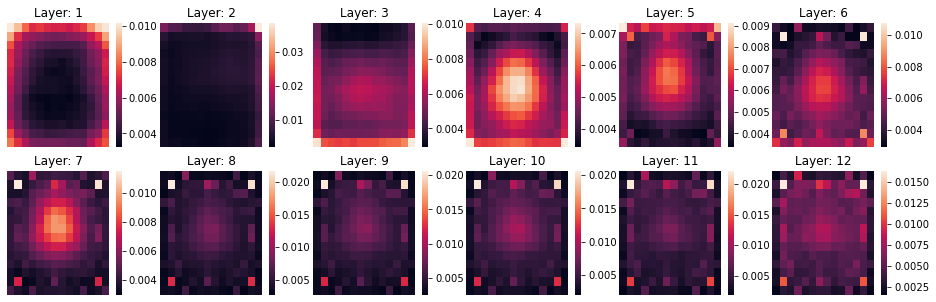

In [26]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
layer = 0
f,axs = plt.subplots(nrows=2, ncols=6,sharex=True,sharey=True,figsize=(16,5))
for ssd_l in ssd:
    ssd_l = ssd_l/total
    ssd_l = ssd_l/torch.sum(ssd_l)
    h = sns.heatmap(ssd_l.cpu().numpy().reshape(14,14),ax=axs.flat[layer])
    h.tick_params(left=False, bottom=False)
    h.tick_params(left=False, bottom=False)
    h.set(xlabel=None,ylabel=None,xticklabels=[],yticklabels=[],title=f'Layer: {layer+1}')
    layer+=1
plt.show()    

Text(0, 0.5, 'Error')

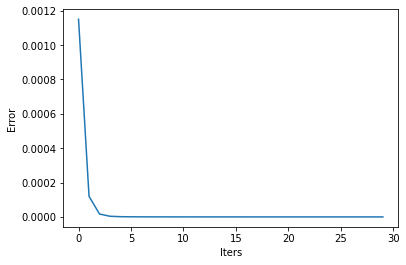

In [29]:
plt.figure()
x = [i for i in range(len(all_iters))]
plt.plot(x,all_iters/total)
plt.xlabel('Iters')
plt.ylabel('Error')